# Multi-period OPF with renewable example

Renewable generations are treated as negative load at each buses.

Renewable generations include current solar (NY-Sun), future solar (GIS), onshore wind (USWTDB), and offshore wind (NYSERDA, GIS).

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from nygrid.nygrid import NYGrid

In [2]:
# Set up directories
cwd = os.getcwd()
if 'examples' in cwd:
    parent_dir = os.path.dirname(cwd)
    data_dir = os.path.join(parent_dir, 'data')
else:
    data_dir = os.path.join(cwd, 'data')

grid_data_dir = os.path.join(data_dir, 'grid')
if not os.path.exists(grid_data_dir):
    raise FileNotFoundError('Grid data directory not found.')

print('Grid data directory: {}'.format(grid_data_dir))

fig_dir = os.path.join(os.path.dirname(data_dir), 'figures')
print('Figure directory: {}'.format(fig_dir))

results_dir = os.path.join(os.path.dirname(data_dir), 'results')
print('Results directory: {}'.format(results_dir))

solar_data_dir = os.path.join(data_dir, 'solar')
print('Solar data directory: {}'.format(solar_data_dir))

onshore_wind_data_dir = os.path.join(data_dir, 'onshore_wind')
print('Onshore wind data directory: {}'.format(onshore_wind_data_dir))

offshore_wind_data_dir = os.path.join(data_dir, 'offshore_wind')
print('Offshore wind data directory: {}'.format(offshore_wind_data_dir))

Grid data directory: D:\EERL\OneMet\NYgrid-python\data\grid
Figure directory: D:\EERL\OneMet\NYgrid-python\figures
Results directory: D:\EERL\OneMet\NYgrid-python\results
Solar data directory: D:\EERL\OneMet\NYgrid-python\data\solar
Onshore wind data directory: D:\EERL\OneMet\NYgrid-python\data\onshore_wind
Offshore wind data directory: D:\EERL\OneMet\NYgrid-python\data\offshore_wind


## Read grid data

### Read generator profiles

In [3]:
start_date = datetime(2018, 1, 1, 0, 0, 0)
end_date = datetime(2019, 1, 1, 0, 0, 0)
timestamp_list = pd.date_range(start_date, end_date, freq='1D')

# Read load profile
load_profile = pd.read_csv(os.path.join(grid_data_dir, f'load_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp').asfreq('H')

# Read generation profile
gen_profile = pd.read_csv(os.path.join(grid_data_dir, f'gen_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp').asfreq('H')

# Read generator capacity limit profile
genmax_profile = pd.read_csv(os.path.join(grid_data_dir, f'genmax_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp').asfreq('H')

genmin_profile = pd.read_csv(os.path.join(grid_data_dir, f'genmin_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp').asfreq('H')

# Read generator ramp rate profile
genramp30_profile = pd.read_csv(os.path.join(grid_data_dir, f'genramp30_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp').asfreq('H')

# Read generator cost profile (linear)
gencost0_profile = pd.read_csv(os.path.join(grid_data_dir, f'gencost0_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp').asfreq('H')

gencost1_profile = pd.read_csv(os.path.join(grid_data_dir, f'gencost1_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp').asfreq('H')

In [4]:
load_profile.sum(axis=1).sort_values(ascending=False)

TimeStamp
2018-08-29 16:00:00    93203.379573
2018-08-29 15:00:00    93195.481205
2018-08-28 16:00:00    93096.897866
2018-08-28 17:00:00    92926.644148
2018-08-29 14:00:00    92834.789049
                           ...     
2018-05-13 05:00:00    35697.114653
2018-10-14 04:00:00    35637.438092
2018-05-14 03:00:00    35606.429683
2018-05-13 03:00:00    35419.794164
2018-05-13 04:00:00    35330.279322
Length: 8760, dtype: float64

### Read variable renewable energy (VRE) data

In [5]:
# Renewable generation time series
current_solar_gen = pd.read_csv(os.path.join(solar_data_dir, f'current_solar_gen_1hr.csv'),
                                parse_dates=['Time'], index_col='Time').asfreq('H')
current_solar_gen.columns = current_solar_gen.columns.astype(int)

future_solar_gen = pd.read_csv(os.path.join(solar_data_dir, f'future_solar_gen_1hr.csv'),
                                parse_dates=['Time'], index_col='Time').asfreq('H')
future_solar_gen.columns = future_solar_gen.columns.astype(int)

onshore_wind_gen = pd.read_csv(os.path.join(onshore_wind_data_dir, f'current_wind_gen_1hr.csv'),
                                parse_dates=['Time'], index_col='Time').asfreq('H')
onshore_wind_gen.columns = onshore_wind_gen.columns.astype(int)

offshore_wind_gen = pd.read_csv(os.path.join(offshore_wind_data_dir, f'power_load_2018.csv'),
                                parse_dates=['timestamp'], index_col='timestamp')
offshore_wind_gen.index = offshore_wind_gen.index.tz_localize('US/Eastern', ambiguous='infer')
offshore_wind_gen.index.freq = 'H'

# Wind farm capacity info
capacity = [816, 1260, 924, 1230]
capacity_nyc, capacity_li = np.sum(capacity[:2]), np.sum(capacity[2:])

# Correct offshore wind generation
offshore_wind_gen['power_nyc'] = np.where(offshore_wind_gen['power_nyc'] > capacity_nyc, capacity_nyc, offshore_wind_gen['power_nyc'])
offshore_wind_gen['power_li'] = np.where(offshore_wind_gen['power_li'] > capacity_li, capacity_li, offshore_wind_gen['power_li'])

In [6]:
# Renewable allocation table
current_solar_2bus = pd.read_csv(os.path.join(solar_data_dir, f'solar_farms_2bus.csv'), index_col='zip_code')
future_solar_2bus = pd.read_csv(os.path.join(solar_data_dir, f'future_solar_farms_2bus.csv'), index_col=0)
onshore_wind_2bus = pd.read_csv(os.path.join(onshore_wind_data_dir, f'onshore_wind_2bus.csv'), index_col=0)

# Aggregate current solar generation
groupby_dict = current_solar_2bus['busIdx'].to_dict()
current_solar_gen_agg = current_solar_gen.groupby(groupby_dict, axis=1).sum()
current_solar_gen_agg = current_solar_gen_agg/1e3 # convert from kW to MW

# Aggregate future solar generation
groupby_dict = future_solar_2bus['busIdx'].to_dict()
future_solar_gen_agg = future_solar_gen.groupby(groupby_dict, axis=1).sum()
future_solar_gen_agg = future_solar_gen_agg/1e3 # convert from kW to MW

# Aggregate onshore wind generation
groupby_dict = onshore_wind_2bus['busIdx'].to_dict()
onshore_wind_gen_agg = onshore_wind_gen.groupby(groupby_dict, axis=1).sum()
onshore_wind_gen_agg = onshore_wind_gen_agg/1e3 # convert from kW to MW

# Aggregate offshore wind generation
offshore_wind_gen_agg = offshore_wind_gen[['power_nyc', 'power_li']].rename(
    columns={'power_nyc': 81, 'power_li': 82})

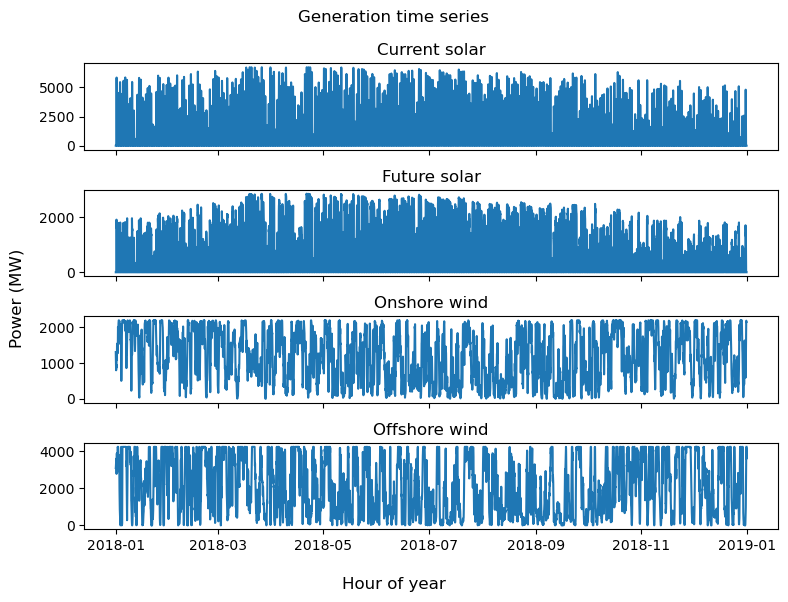

In [7]:
fig, axs = plt.subplots(4, 1, figsize=(8, 6),
                        sharex='all')
axs[0].plot(current_solar_gen_agg.sum(axis=1), label='Current solar')
axs[1].plot(future_solar_gen_agg.sum(axis=1), label='Future solar')
axs[2].plot(onshore_wind_gen_agg.sum(axis=1), label='Onshore wind')
axs[3].plot(offshore_wind_gen_agg.sum(axis=1), label='Offshore wind')

titles = ['Current solar', 'Future solar', 'Onshore wind', 'Offshore wind']

for i, ax in enumerate(axs):
    ax.set_title(titles[i])

fig.supxlabel('Hour of year')
fig.supylabel('Power (MW)')
fig.suptitle('Generation time series')
fig.tight_layout()

In [8]:
# 18.08% of current solar generation is built before 2018 (base year)
# Scale down current solar generation by 18.08%
pct_current_solar_built = 0.1808
current_solar_gen_agg = current_solar_gen_agg * (1-pct_current_solar_built)

# 90.6% of onshore wind generation is built before 2018 (base year)
# Scale down onshore wind generation by 90.6%
pct_onshore_wind_built = 0.906
onshore_wind_gen_agg = onshore_wind_gen_agg * (1-pct_onshore_wind_built)

In [9]:
vre_profiles = {'CurSol': current_solar_gen_agg,
                'FutSol': future_solar_gen_agg,
                'OnWind': onshore_wind_gen_agg,
                'OffWind': offshore_wind_gen_agg}
vre_prop_list = list()
for key, profile in vre_profiles.items():
    vre_prop_a = pd.DataFrame(data={'VRE_BUS': profile.columns,
                                    'VRE_PMAX': profile.max(axis=0),
                                    'VRE_PMIN': 0,
                                    'VRE_TYPE': 'Solar',
                                    'VRE_NAME': [f'{key}_{col}' for col in profile.columns]})
    vre_prop_list.append(vre_prop_a)
    
# Combine gen_prop tables
vre_prop = pd.concat(vre_prop_list, ignore_index=True)
vre_prop

,VRE_BUS,VRE_PMAX,VRE_PMIN,VRE_TYPE,VRE_NAME
0,37,77.904033,0,Solar,CurSol_37
1,38,68.687396,0,Solar,CurSol_38
2,39,90.918845,0,Solar,CurSol_39
3,40,76.602936,0,Solar,CurSol_40
4,41,89.028742,0,Solar,CurSol_41
...,...,...,...,...,...
86,69,0.000000,0,Solar,OnWind_69
87,80,0.009400,0,Solar,OnWind_80
88,81,0.000000,0,Solar,OnWind_81
89,81,2076.000000,0,Solar,OffWind_81


In [10]:
# Combine genmax tables
genmax_profile_vre = pd.concat([current_solar_gen_agg, future_solar_gen_agg,
                                onshore_wind_gen_agg, offshore_wind_gen_agg], axis=1)
genmax_profile_vre.columns = vre_prop['VRE_NAME']
genmax_profile_vre.index = genmax_profile_vre.index.tz_convert('US/Eastern').tz_localize(None)
genmax_profile_vre

VRE_NAME,CurSol_37,CurSol_38,CurSol_39,CurSol_40,CurSol_41,CurSol_42,CurSol_43,CurSol_44,CurSol_45,CurSol_46,...,OnWind_58,OnWind_60,OnWind_62,OnWind_64,OnWind_65,OnWind_69,OnWind_80,OnWind_81,OffWind_81,OffWind_82
2018-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.051012,11.666778,14.066085,15.563729,0.210635,0.0,0.007795,0.0,1005.664992,2088.625000
2018-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.039893,9.747859,11.439783,10.980977,0.210908,0.0,0.005606,0.0,1116.157083,1994.529683
2018-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.023814,7.386271,10.941958,8.323365,0.203995,0.0,0.005741,0.0,1260.128017,1935.640300
2018-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.005331,5.564034,8.778212,9.253707,0.148417,0.0,0.006201,0.0,1340.852150,1965.535867
2018-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000283,1.275872,7.919764,9.198507,0.083164,0.0,0.007014,0.0,1356.833000,2088.592100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.166850,19.241800,23.583720,18.475700,0.310200,0.0,0.009379,0.0,2076.000000,1575.333583
2018-12-31 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.166850,19.241800,23.586480,18.475700,0.310200,0.0,0.009389,0.0,2076.000000,2107.629567
2018-12-31 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.166850,19.220258,23.586480,18.475700,0.310200,0.0,0.009400,0.0,1638.623567,2154.000000
2018-12-31 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.166850,19.190100,23.586480,18.475700,0.310200,0.0,0.008107,0.0,1425.989483,2154.000000


### Read DC line and ESR properties

In [11]:
# Read DC line property file
filename = os.path.join(grid_data_dir, 'dcline_prop.csv')
dcline_prop = pd.read_csv(filename, index_col=0)
dcline_prop

,DC_F_BUS,DC_T_BUS,DC_BR_STATUS,DC_PF,DC_PT,DC_QF,DC_QT,DC_VF,DC_VT,DC_PMIN,DC_PMAX,DC_QMINF,DC_QMAXF,DC_QMINT,DC_QMAXT,LOSS0,LOSS1,FROM_ZONE,TO_ZONE
0,21,80,1,12.666667,0,0,0,1.01,1,-530,530,-100,100,-100,100,0,0,NE,K
1,124,79,1,660.000000,0,0,0,1.01,1,-660,660,-100,100,-100,100,0,0,PJM,K
2,125,81,1,599.166667,0,0,0,1.01,1,-660,660,-100,100,-100,100,0,0,PJM,J
3,125,81,1,223.166667,0,0,0,1.01,1,-660,660,-100,100,-100,100,0,0,PJM,J
4,48,81,1,0.000000,0,0,0,1.01,1,-1250,1250,-100,100,-100,100,0,0,D,J
5,69,81,1,0.000000,0,0,0,1.01,1,-1300,1300,-100,100,-100,100,0,0,E,J


In [12]:
filename = os.path.join(grid_data_dir, 'esr_prop.csv')
esr_prop = pd.read_csv(filename, index_col=0)
esr_prop

,ESR_NAME,ESR_BUS,ESR_STATUS,ESR_CRG_MAX,ESR_DIS_MAX,ESR_CRG_EFF,ESR_DIS_EFF,ESR_SOC_MIN,ESR_SOC_MAX,ESR_SOC_INI,ESR_SOC_TGT,ESR_CRG_COST,ESR_DIS_COST,ESR_ZONE
0,Gilboa 1 (IIFO - 1/1/2019),42,1,280.0,291.8,0.67,0.67,0,3000,1500,1500,0.005,0.005,F
1,Gilboa 2,42,1,280.0,292.7,0.67,0.67,0,3000,1500,1500,0.005,0.005,F
2,Gilboa 3,42,1,280.0,291.9,0.67,0.67,0,3000,1500,1500,0.005,0.005,F
3,Gilboa 4,42,1,280.0,292.5,0.67,0.67,0,3000,1500,1500,0.005,0.005,F
4,Lewiston PS,56,1,230.0,240.0,0.59,0.59,0,2880,1440,1440,0.005,0.005,A
5,North County Energy Storage,47,1,20.0,20.0,0.85,0.85,0,200,100,100,0.005,0.005,E
6,zzAgg_J_ES__1,82,1,2.0,2.0,0.85,0.85,0,8,4,4,0.005,0.005,J
7,zzAgg_K_FC__1,80,1,18.5,18.5,0.85,0.85,0,74,37,37,0.005,0.005,K
8,A_ESR_Standalone,56,1,300.0,300.0,0.85,0.85,0,1200,600,600,0.005,0.005,A
9,B_ESR_Standalone,53,1,180.0,180.0,0.85,0.85,0,720,360,360,0.005,0.005,B


## Multi-period OPF

### Without initial conditions

In [13]:
# Only run for one day
d = 240
start_datetime = timestamp_list[d]
end_datetime = start_datetime + timedelta(hours=23)
print(f'Start time: {start_datetime}')
print(f'End time: {end_datetime}')

Start time: 2018-08-29 00:00:00
End time: 2018-08-29 23:00:00


#### Without ESR

In [14]:
# Create NYGrid object
nygrid_sim_wo_esr = NYGrid(grid_data_dir, 
                            start_datetime=start_datetime.strftime('%m-%d-%Y %H'), 
                            end_datetime=end_datetime.strftime('%m-%d-%Y %H'),
                            dcline_prop=dcline_prop,
                            esr_prop=None,
                            vre_prop=None,
                            verbose=True)

# Set load and generation time series data
nygrid_sim_wo_esr.set_load_sch(load_profile)
nygrid_sim_wo_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_wo_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_wo_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_wo_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_wo_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_wo_esr.relax_external_branch_lim()

# Set generator initial condition
nygrid_sim_wo_esr.set_gen_init_data(gen_init=None)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_wo_esr.set_options(options)

# Solve DC OPF
nygrid_sim_wo_esr.solve_dc_opf()

# Get results
results_0_wo_esr = nygrid_sim_wo_esr.get_results_dc_opf()

Number of buses: 57
Number of generators: 315
Number of branches: 94
Number of time periods: 24
Number of variables: 32760
Number of constraints: 39810
Set parameter Username
Academic license - for non-commercial use only - expires 2024-07-12
skipping further warning of this kind
Read LP format model from file C:\Users\xjtuy\AppData\Local\Temp\tmpdnqvxo6n.pyomo.lp
Reading time = 0.18 seconds
x1: 39810 rows, 32761 columns, 200646 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 39810 rows, 32761 columns and 200646 nonzeros
Model fingerprint: 0xcf1a41ae
Coefficient statistics:
  Matrix range     [3e-06, 1e+00]
  Objective range  [3e+00, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...
Presolve removed 36630 rows and 24877 

In [15]:
print("s_ramp_up", results_0_wo_esr['s_ramp_up'].sum())
print("s_ramp_down", results_0_wo_esr['s_ramp_down'].sum())
print("s_over_gen", results_0_wo_esr['s_over_gen'].sum())
print("s_load_shed", results_0_wo_esr['s_load_shed'].sum())
print("s_if_max", results_0_wo_esr['s_if_max'].sum())
print("s_if_min", results_0_wo_esr['s_if_min'].sum())
print("s_br_max", results_0_wo_esr['s_br_max'].sum())
print("s_br_min", results_0_wo_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 0.0
s_if_min 0.0
s_br_max 0.0
s_br_min 0.0


#### With ESR

In [16]:
# Create NYGrid object
nygrid_sim_w_esr = NYGrid(grid_data_dir, 
                          start_datetime=start_datetime.strftime('%m-%d-%Y %H'), 
                          end_datetime=end_datetime.strftime('%m-%d-%Y %H'),
                          dcline_prop=dcline_prop,
                          esr_prop=esr_prop,
                          vre_prop=None,
                          verbose=True)

# Set load and generation time series data
nygrid_sim_w_esr.set_load_sch(load_profile)
nygrid_sim_w_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_w_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_w_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_w_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_w_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_w_esr.relax_external_branch_lim()

# Set generator initial condition
nygrid_sim_w_esr.set_gen_init_data(gen_init=None)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_w_esr.set_options(options)

# Solve DC OPF
nygrid_sim_w_esr.solve_dc_opf()

# Get results
results_0_w_esr = nygrid_sim_w_esr.get_results_dc_opf()

Number of buses: 57
Number of generators: 345
Number of branches: 94
Number of time periods: 24
Number of variables: 37080
Number of constraints: 46980
Set parameter Username
Academic license - for non-commercial use only - expires 2024-07-12
skipping further warning of this kind
Read LP format model from file C:\Users\xjtuy\AppData\Local\Temp\tmpe5akgb9_.pyomo.lp
Reading time = 0.18 seconds
x1: 46980 rows, 37081 columns, 215586 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 46980 rows, 37081 columns and 215586 nonzeros
Model fingerprint: 0x38a41128
Coefficient statistics:
  Matrix range     [3e-06, 2e+00]
  Objective range  [5e-01, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...
Presolve removed 43073 rows and 27060 

In [17]:
print("s_ramp_up", results_0_w_esr['s_ramp_up'].sum())
print("s_ramp_down", results_0_w_esr['s_ramp_down'].sum())
print("s_over_gen", results_0_w_esr['s_over_gen'].sum())
print("s_load_shed", results_0_w_esr['s_load_shed'].sum())
print("s_if_max", results_0_w_esr['s_if_max'].sum())
print("s_if_min", results_0_w_esr['s_if_min'].sum())
print("s_br_max", results_0_w_esr['s_br_max'].sum())
print("s_br_min", results_0_w_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 0.0
s_if_min 0.0
s_br_max 0.0
s_br_min 0.0


#### With VRE

In [18]:
# Create NYGrid object
nygrid_sim_w_vre = NYGrid(grid_data_dir, 
                          start_datetime=start_datetime.strftime('%m-%d-%Y %H'), 
                          end_datetime=end_datetime.strftime('%m-%d-%Y %H'),
                          dcline_prop=dcline_prop,
                          esr_prop=None,
                          vre_prop=vre_prop,
                          verbose=True)

# Set load and generation time series data
nygrid_sim_w_vre.set_load_sch(load_profile)
nygrid_sim_w_vre.set_gen_mw_sch(gen_profile)
nygrid_sim_w_vre.set_gen_max_sch(genmax_profile)
nygrid_sim_w_vre.set_vre_max_sch(genmax_profile_vre)
nygrid_sim_w_vre.set_gen_min_sch(genmin_profile)
nygrid_sim_w_vre.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_w_vre.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_w_vre.relax_external_branch_lim()

# Set generator initial condition
nygrid_sim_w_vre.set_gen_init_data(gen_init=None)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_w_vre.set_options(options)

# Solve DC OPF
nygrid_sim_w_vre.solve_dc_opf()

# Get results
results_0_w_vre = nygrid_sim_w_vre.get_results_dc_opf()

Number of buses: 57
Number of generators: 406
Number of branches: 94
Number of time periods: 24
Number of variables: 39312
Number of constraints: 48364
Set parameter Username
Academic license - for non-commercial use only - expires 2024-07-12
skipping further warning of this kind
Read LP format model from file C:\Users\xjtuy\AppData\Local\Temp\tmpo_wwjl9y.pyomo.lp
Reading time = 0.20 seconds
x1: 48364 rows, 39313 columns, 221940 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 48364 rows, 39313 columns and 221940 nonzeros
Model fingerprint: 0xceba4eb1
Coefficient statistics:
  Matrix range     [3e-06, 1e+00]
  Objective range  [3e+00, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...
Presolve removed 44923 rows and 30373 

In [19]:
print("s_ramp_up", results_0_w_vre['s_ramp_up'].sum())
print("s_ramp_down", results_0_w_vre['s_ramp_down'].sum())
print("s_over_gen", results_0_w_vre['s_over_gen'].sum())
print("s_load_shed", results_0_w_vre['s_load_shed'].sum())
print("s_if_max", results_0_w_vre['s_if_max'].sum())
print("s_if_min", results_0_w_vre['s_if_min'].sum())
print("s_br_max", results_0_w_vre['s_br_max'].sum())
print("s_br_min", results_0_w_vre['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 0.0
s_if_min 0.0
s_br_max 0.0
s_br_min 0.0


#### With VRE and ESR

In [20]:
# Create NYGrid object
nygrid_sim_w_vre_esr = NYGrid(grid_data_dir, 
                          start_datetime=start_datetime.strftime('%m-%d-%Y %H'), 
                          end_datetime=end_datetime.strftime('%m-%d-%Y %H'),
                          dcline_prop=dcline_prop,
                          esr_prop=esr_prop,
                          vre_prop=vre_prop,
                          verbose=True)

# Set load and generation time series data
nygrid_sim_w_vre_esr.set_load_sch(load_profile)
nygrid_sim_w_vre_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_w_vre_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_w_vre_esr.set_vre_max_sch(genmax_profile_vre)
nygrid_sim_w_vre_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_w_vre_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_w_vre_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_w_vre_esr.relax_external_branch_lim()

# Set generator initial condition
nygrid_sim_w_vre_esr.set_gen_init_data(gen_init=None)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_w_vre_esr.set_options(options)

# Solve DC OPF
nygrid_sim_w_vre_esr.solve_dc_opf()

# Get results
results_0_w_vre_esr = nygrid_sim_w_vre_esr.get_results_dc_opf()

Number of buses: 57
Number of generators: 436
Number of branches: 94
Number of time periods: 24
Number of variables: 43632
Number of constraints: 55534
Set parameter Username
Academic license - for non-commercial use only - expires 2024-07-12
skipping further warning of this kind
Read LP format model from file C:\Users\xjtuy\AppData\Local\Temp\tmpj6a_d6rp.pyomo.lp
Reading time = 0.22 seconds
x1: 55534 rows, 43633 columns, 236880 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 55534 rows, 43633 columns and 236880 nonzeros
Model fingerprint: 0x880c74f9
Coefficient statistics:
  Matrix range     [3e-06, 2e+00]
  Objective range  [5e-01, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 51381 rows and 32584

In [21]:
print("s_ramp_up", results_0_w_vre_esr['s_ramp_up'].sum())
print("s_ramp_down", results_0_w_vre_esr['s_ramp_down'].sum())
print("s_over_gen", results_0_w_vre_esr['s_over_gen'].sum())
print("s_load_shed", results_0_w_vre_esr['s_load_shed'].sum())
print("s_if_max", results_0_w_vre_esr['s_if_max'].sum())
print("s_if_min", results_0_w_vre_esr['s_if_min'].sum())
print("s_br_max", results_0_w_vre_esr['s_br_max'].sum())
print("s_br_min", results_0_w_vre_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 0.0
s_if_min 0.0
s_br_max 0.0
s_br_min 0.0


#### Results

In [22]:
ii = 5
print('total', nygrid_sim_w_esr.model.PG[:, nygrid_sim_w_esr.esr_idx[ii]]())
print('discharging', nygrid_sim_w_esr.model.esrPDis[:, ii]())
print('charging', nygrid_sim_w_esr.model.esrPCrg[:, ii]())
print('SOC', nygrid_sim_w_esr.model.esrSOC[:, ii]())

total [0.0, 0.0, -0.2, -0.17647058823529455, -0.2, 0.0, -0.2, -0.2, -0.2, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.19449999999999984, 0.0, 0.0, 0.0, 0.0, 0.0, -0.2]
discharging [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.19449999999999984, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
charging [0.0, 0.0, 0.2, 0.17647058823529455, 0.2, 0.0, 0.2, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2]
SOC [1.0, 1.0, 1.17, 1.3200000000000003, 1.4900000000000002, 1.4900000000000002, 1.6600000000000001, 1.83, 2.0, 2.0, 2.0, 2.0, 2.0, 1.7647058823529411, 1.5294117647058822, 1.2941176470588234, 1.0588235294117645, 0.83, 0.83, 0.83, 0.83, 0.83, 0.83, 1.0]


In [23]:
print(f'Total cost: {results_0_wo_esr["total_cost"].sum():.2f}, {results_0_w_esr["total_cost"].sum():.2f}, {results_0_w_vre["total_cost"].sum():.2f}, {results_0_w_vre_esr["total_cost"].sum():.2f}')
print(f'Gen cost: {results_0_wo_esr["gen_cost"].sum():.2f}, {results_0_w_esr["gen_cost"].sum():.2f}, {results_0_w_vre["gen_cost"].sum():.2f}, {results_0_w_vre_esr["gen_cost"].sum():.2f}')
print(f'Over generation penalty: {results_0_wo_esr["over_gen_penalty"].sum():.2f}, {results_0_w_esr["over_gen_penalty"].sum():.2f}, {results_0_w_vre["over_gen_penalty"].sum():.2f}, {results_0_w_vre_esr["over_gen_penalty"].sum():.2f}')
print(f'Load shed penalty: {results_0_wo_esr["load_shed_penalty"].sum():.2f}, {results_0_w_esr["load_shed_penalty"].sum():.2f}, {results_0_w_vre["load_shed_penalty"].sum():.2f}, {results_0_w_vre_esr["load_shed_penalty"].sum():.2f}')
print(f'Ramp up penalty: {results_0_wo_esr["ramp_up_penalty"].sum():.2f}, {results_0_w_esr["ramp_up_penalty"].sum():.2f}, {results_0_w_vre["ramp_up_penalty"].sum():.2f}, {results_0_w_vre_esr["ramp_up_penalty"].sum():.2f}')
print(f'Ramp down penalty: {results_0_wo_esr["ramp_down_penalty"].sum():.2f}, {results_0_w_esr["ramp_down_penalty"].sum():.2f}, {results_0_w_vre["ramp_down_penalty"].sum():.2f}, {results_0_w_vre_esr["ramp_down_penalty"].sum():.2f}')
print(f'Interface max penalty: {results_0_wo_esr["if_max_penalty"].sum():.2f}, {results_0_w_esr["if_max_penalty"].sum():.2f}, {results_0_w_vre["if_max_penalty"].sum():.2f}, {results_0_w_vre_esr["if_max_penalty"].sum():.2f}')
print(f'Interface min penalty: {results_0_wo_esr["if_min_penalty"].sum():.2f}, {results_0_w_esr["if_min_penalty"].sum():.2f}, {results_0_w_vre["if_min_penalty"].sum():.2f}, {results_0_w_vre_esr["if_min_penalty"].sum():.2f}')
print(f'Branch max penalty: {results_0_wo_esr["br_max_penalty"].sum():.2f}, {results_0_w_esr["br_max_penalty"].sum():.2f}, {results_0_w_vre["br_max_penalty"].sum():.2f}, {results_0_w_vre_esr["br_max_penalty"].sum():.2f}')
print(f'Branch min penalty: {results_0_wo_esr["br_min_penalty"].sum():.2f}, {results_0_w_esr["br_min_penalty"].sum():.2f}, {results_0_w_vre["br_min_penalty"].sum():.2f}, {results_0_w_vre_esr["br_min_penalty"].sum():.2f}')

Total cost: 71687843.88, 70132976.46, 64994485.29, 63489789.89
Gen cost: 71687843.88, 70132976.46, 64994485.29, 63489789.89
Over generation penalty: 0.00, 0.00, 0.00, 0.00
Load shed penalty: 0.00, 0.00, 0.00, 0.00
Ramp up penalty: 0.00, 0.00, 0.00, 0.00
Ramp down penalty: 0.00, 0.00, 0.00, 0.00
Interface max penalty: 0.00, 0.00, 0.00, 0.00
Interface min penalty: 0.00, 0.00, 0.00, 0.00
Branch max penalty: 0.00, 0.00, 0.00, 0.00
Branch min penalty: 0.00, 0.00, 0.00, 0.00


In [24]:
# Create a dict where key is busIdx and value is zoneID
bus_zone_alloc = nygrid_sim_w_esr.grid_data['bus_prop'].set_index('BUS_I').to_dict()['BUS_ZONE']
bus_names = list(bus_zone_alloc.keys())
bus_names_str = [f'Bus{i}' for i in bus_names]

In [25]:
lmp_wo_esr = results_0_wo_esr['LMP']
lmp_wo_esr.columns = bus_names

lmp_w_esr = results_0_w_esr['LMP']
lmp_w_esr.columns = bus_names

lmp_w_vre = results_0_w_vre['LMP']
lmp_w_vre.columns = bus_names

lmp_w_vre_esr = results_0_w_vre_esr['LMP']
lmp_w_vre_esr.columns = bus_names

# Aggregate LMPs by zone
lmp_wo_esr_zone = lmp_wo_esr.groupby(bus_zone_alloc, axis=1).mean()
lmp_w_esr_zone = lmp_w_esr.groupby(bus_zone_alloc, axis=1).mean()
lmp_w_vre_zone = lmp_w_vre.groupby(bus_zone_alloc, axis=1).mean()
lmp_w_vre_esr_zone = lmp_w_vre_esr.groupby(bus_zone_alloc, axis=1).mean()

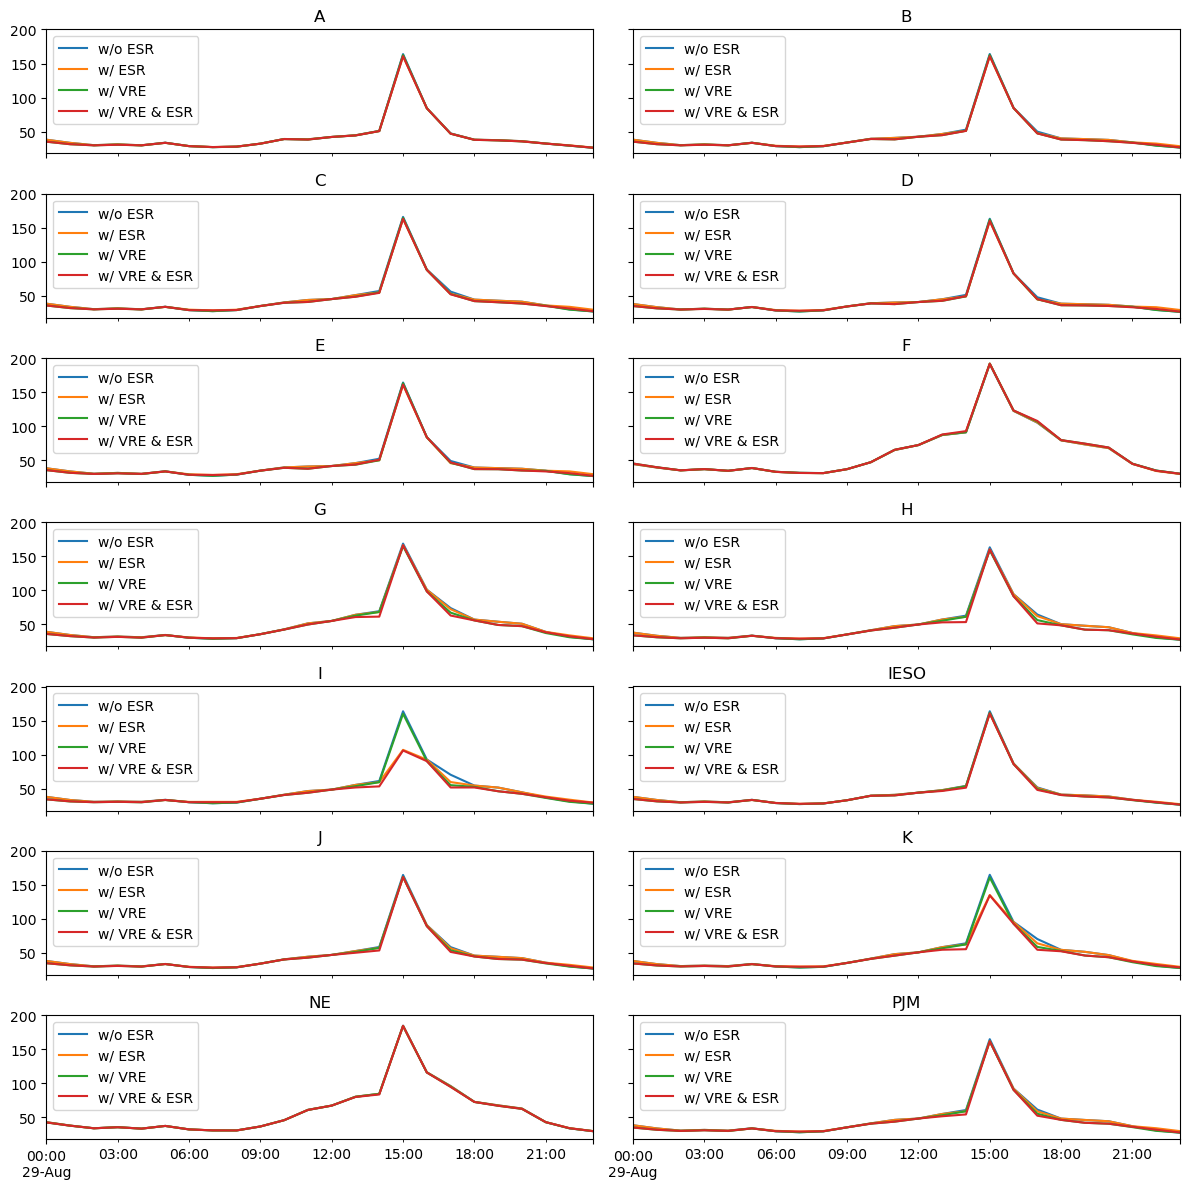

In [26]:
fig, axs = plt.subplots(7, 2, figsize=(12, 12), sharex='all', sharey='all')
# Plot LMPs w/o ESR
for i, ax in enumerate(axs.flat):
    lmp_wo_esr_zone.iloc[:, i].plot(ax=ax, label='w/o ESR')
    lmp_w_esr_zone.iloc[:, i].plot(ax=ax, label='w/ ESR')
    lmp_w_vre_zone.iloc[:, i].plot(ax=ax, label='w/ VRE')
    lmp_w_vre_esr_zone.iloc[:, i].plot(ax=ax, label='w/ VRE & ESR')
    ax.set_title(lmp_w_esr_zone.columns[i])
    ax.legend()
    
fig.tight_layout()

<AxesSubplot:title={'center':'Zonal Load'}, xlabel='TimeStamp'>

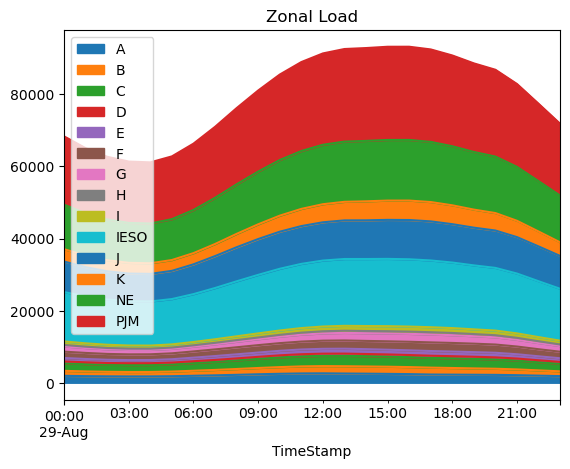

In [27]:
load_profile.columns = bus_names
load_profile_zone = load_profile.groupby(bus_zone_alloc, axis=1).sum()
load_profile_zone[start_datetime:end_datetime].plot.area(title="Zonal Load")

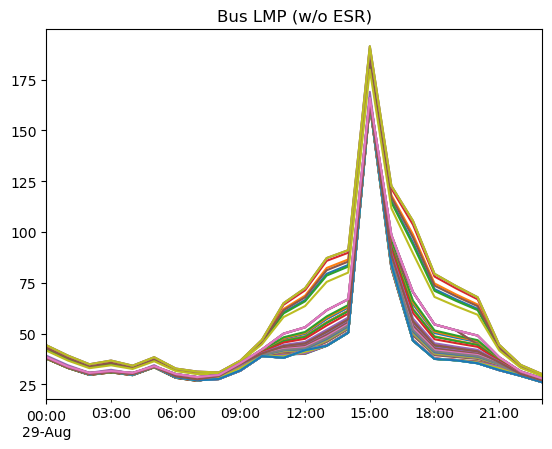

In [28]:
results_0_wo_esr['LMP'].plot(legend=False, title="Bus LMP (w/o ESR)")
plt.show()

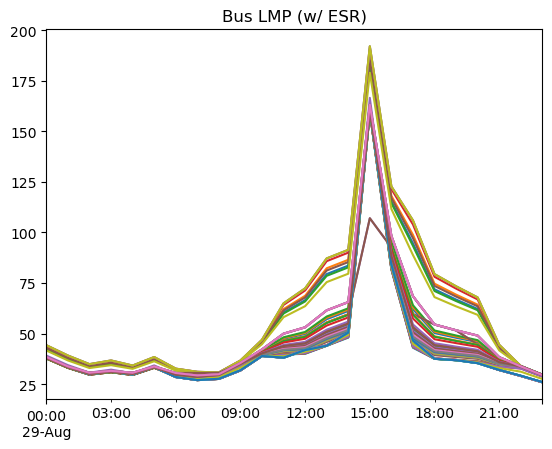

In [29]:
results_0_w_esr['LMP'].plot(legend=False, title="Bus LMP (w/ ESR)")
plt.show()

In [30]:
gen_max = genmax_profile[start_datetime:end_datetime]
gen_pg = results_0_wo_esr['PG'].iloc[:, :303]
gen_pg.columns = gen_max.columns
surplus = gen_max - gen_pg
surplus

,Gen1,Gen2,Gen3,Gen4,Gen5,Gen6,Gen7,Gen8,Gen9,Gen10,...,Gen294,Gen295,Gen296,Gen297,Gen298,Gen299,Gen300,Gen301,Gen302,Gen303
TimeStamp,,,,,,,,,,,,,,,,,,,,,
2018-08-29 00:00:00,17.1,18.5,18.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00
2018-08-29 01:00:00,17.1,18.5,18.5,0.0,0.0,0.0,20.0,0.0,0.0,0.0,...,0.0,0.0,-2.220446e-16,0.000000e+00,0.000000e+00,8.881784e-16,0.0,0.000000e+00,0.0,0.000000e+00
2018-08-29 02:00:00,17.1,18.5,18.5,0.0,0.0,0.0,20.0,0.0,0.0,152.0,...,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00
2018-08-29 03:00:00,17.1,18.5,18.5,0.0,0.0,0.0,20.0,0.0,0.0,152.0,...,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00
2018-08-29 04:00:00,17.1,18.5,18.5,0.0,0.0,0.0,20.0,0.0,0.0,152.0,...,0.0,0.0,-2.220446e-16,0.000000e+00,-8.881784e-16,-8.881784e-16,0.0,0.000000e+00,0.0,0.000000e+00
2018-08-29 05:00:00,17.1,18.5,18.5,0.0,0.0,0.0,20.0,0.0,0.0,0.0,...,0.0,0.0,-2.220446e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00
2018-08-29 06:00:00,17.1,18.5,18.5,0.0,0.0,0.0,20.0,0.0,0.0,152.0,...,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,-3.552714e-15,0.0,0.000000e+00
2018-08-29 07:00:00,17.1,18.5,18.5,0.0,0.0,0.0,20.0,0.0,0.0,152.0,...,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00
2018-08-29 08:00:00,17.1,18.5,18.5,0.0,0.0,0.0,20.0,0.0,0.0,152.0,...,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,8.881784e-16,0.0,0.000000e+00,0.0,0.000000e+00


### With initial conditions

In [31]:
# Only run for one day
d = d+1
start_datetime = timestamp_list[d]
end_datetime = start_datetime + timedelta(hours=47)
print(f'Start time: {start_datetime}')
print(f'End time: {end_datetime}')

Start time: 2018-08-30 00:00:00
End time: 2018-08-31 23:00:00


#### Without ESR

In [32]:
# Create NYGrid object
nygrid_sim_1_wo_esr = NYGrid(grid_data_dir, 
                            start_datetime=start_datetime.strftime('%m-%d-%Y %H'), 
                            end_datetime=end_datetime.strftime('%m-%d-%Y %H'),
                            dcline_prop=dcline_prop,
                            esr_prop=None,
                            verbose=True)

# Set load and generation time series data
nygrid_sim_1_wo_esr.set_load_sch(load_profile)
nygrid_sim_1_wo_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_1_wo_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_1_wo_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_1_wo_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_1_wo_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_1_wo_esr.relax_external_branch_lim()

# Set generator initial condition
last_gen = results_0_wo_esr['PG'].loc[start_datetime].to_numpy().squeeze()
nygrid_sim_1_wo_esr.set_gen_init_data(gen_init=last_gen)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_1_wo_esr.set_options(options)

# Solve DC OPF
nygrid_sim_1_wo_esr.solve_dc_opf()

# Get results
results_1_wo_esr = nygrid_sim_1_wo_esr.get_results_dc_opf()

KeyError: Timestamp('2018-08-30 00:00:00')

In [ ]:
print("s_ramp_up", results_1_wo_esr['s_ramp_up'].sum())
print("s_ramp_down", results_1_wo_esr['s_ramp_down'].sum())
print("s_over_gen", results_1_wo_esr['s_over_gen'].sum())
print("s_load_shed", results_1_wo_esr['s_load_shed'].sum())
print("s_if_max", results_1_wo_esr['s_if_max'].sum())
print("s_if_min", results_1_wo_esr['s_if_min'].sum())
print("s_br_max", results_1_wo_esr['s_br_max'].sum())
print("s_br_min", results_1_wo_esr['s_br_min'].sum())

#### With ESR

In [ ]:
# Create NYGrid object
nygrid_sim_1_w_esr = NYGrid(grid_data_dir, 
                            start_datetime=start_datetime.strftime('%m-%d-%Y %H'), 
                            end_datetime=end_datetime.strftime('%m-%d-%Y %H'),
                            dcline_prop=dcline_prop,
                            esr_prop=esr_prop,
                            verbose=True)

# Set load and generation time series data
nygrid_sim_1_w_esr.set_load_sch(load_profile)
nygrid_sim_1_w_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_1_w_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_1_w_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_1_w_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_1_w_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_1_w_esr.relax_external_branch_lim()

# Set generator initial condition
last_gen = results_0_w_esr['PG'].loc[start_datetime].to_numpy().squeeze()
nygrid_sim_1_w_esr.set_gen_init_data(gen_init=last_gen)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_1_w_esr.set_options(options)

# Solve DC OPF
nygrid_sim_1_w_esr.solve_dc_opf()

# Get results
results_1_w_esr = nygrid_sim_1_w_esr.get_results_dc_opf()

In [ ]:
print("s_ramp_up", results_1_w_esr['s_ramp_up'].sum())
print("s_ramp_down", results_1_w_esr['s_ramp_down'].sum())
print("s_over_gen", results_1_w_esr['s_over_gen'].sum())
print("s_load_shed", results_1_w_esr['s_load_shed'].sum())
print("s_if_max", results_1_w_esr['s_if_max'].sum())
print("s_if_min", results_1_w_esr['s_if_min'].sum())
print("s_br_max", results_1_w_esr['s_br_max'].sum())
print("s_br_min", results_1_w_esr['s_br_min'].sum())

#### With VRE

In [ ]:
# Create NYGrid object
nygrid_sim_1_w_vre = NYGrid(grid_data_dir, 
                            start_datetime=start_datetime.strftime('%m-%d-%Y %H'), 
                            end_datetime=end_datetime.strftime('%m-%d-%Y %H'),
                            dcline_prop=dcline_prop,
                            esr_prop=None,
                            vre_prop=vre_prop,
                            verbose=True)

# Set load and generation time series data
nygrid_sim_1_w_vre.set_load_sch(load_profile)
nygrid_sim_1_w_vre.set_gen_mw_sch(gen_profile)
nygrid_sim_1_w_vre.set_gen_max_sch(genmax_profile)
nygrid_sim_1_w_vre.set_vre_max_sch(genmax_profile_vre)
nygrid_sim_1_w_vre.set_gen_min_sch(genmin_profile)
nygrid_sim_1_w_vre.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_1_w_vre.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_1_w_vre.relax_external_branch_lim()

# Set generator initial condition
last_gen = results_0_w_vre['PG'].loc[start_datetime].to_numpy().squeeze()
nygrid_sim_1_w_vre.set_gen_init_data(gen_init=last_gen)

# Set options
# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_1_w_vre.set_options(options)

# Solve DC OPF
nygrid_sim_1_w_vre.solve_dc_opf()

# Get results
results_1_w_vre = nygrid_sim_1_w_vre.get_results_dc_opf()

In [ ]:
print("s_ramp_up", results_1_w_vre['s_ramp_up'].sum())
print("s_ramp_down", results_1_w_vre['s_ramp_down'].sum())
print("s_over_gen", results_1_w_vre['s_over_gen'].sum())
print("s_load_shed", results_1_w_vre['s_load_shed'].sum())
print("s_if_max", results_1_w_vre['s_if_max'].sum())
print("s_if_min", results_1_w_vre['s_if_min'].sum())
print("s_br_max", results_1_w_vre['s_br_max'].sum())
print("s_br_min", results_1_w_vre['s_br_min'].sum())

#### With VRE and ESR

In [ ]:
# Create NYGrid object
nygrid_sim_1_w_vre_esr = NYGrid(grid_data_dir, 
                            start_datetime=start_datetime.strftime('%m-%d-%Y %H'), 
                            end_datetime=end_datetime.strftime('%m-%d-%Y %H'),
                            dcline_prop=dcline_prop,
                            esr_prop=esr_prop,
                            vre_prop=vre_prop,
                            verbose=True)

# Set load and generation time series data
nygrid_sim_1_w_vre_esr.set_load_sch(load_profile)
nygrid_sim_1_w_vre_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_1_w_vre_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_1_w_vre_esr.set_vre_max_sch(genmax_profile_vre)
nygrid_sim_1_w_vre_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_1_w_vre_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_1_w_vre_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_1_w_vre_esr.relax_external_branch_lim()

# Set generator initial condition
last_gen = results_0_w_vre_esr['PG'].loc[start_datetime].to_numpy().squeeze()
nygrid_sim_1_w_vre_esr.set_gen_init_data(gen_init=last_gen)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_1_w_vre_esr.set_options(options)

# Solve DC OPF
nygrid_sim_1_w_vre_esr.solve_dc_opf()

# Get results
results_1_w_vre_esr = nygrid_sim_1_w_vre_esr.get_results_dc_opf()

In [ ]:
print("s_ramp_up", results_1_w_vre_esr['s_ramp_up'].sum())
print("s_ramp_down", results_1_w_vre_esr['s_ramp_down'].sum())
print("s_over_gen", results_1_w_vre_esr['s_over_gen'].sum())
print("s_load_shed", results_1_w_vre_esr['s_load_shed'].sum())
print("s_if_max", results_1_w_vre_esr['s_if_max'].sum())
print("s_if_min", results_1_w_vre_esr['s_if_min'].sum())
print("s_br_max", results_1_w_vre_esr['s_br_max'].sum())
print("s_br_min", results_1_w_vre_esr['s_br_min'].sum())

## Process the results

In [ ]:
# Read thermal generator info table
filename = os.path.join(data_dir, 'genInfo.csv')
gen_info = pd.read_csv(filename)
num_thermal = gen_info.shape[0]
gen_rename = {gen_info.index[i]: gen_info.NYISOName[i] for i in range(num_thermal)}
gen_info

In [ ]:
# Format results
results_pg_0_wo_esr = results_0_wo_esr['PG']
thermal_pg_0_wo_esr = results_pg_0_wo_esr.iloc[:, :num_thermal]
thermal_pg_0_wo_esr = thermal_pg_0_wo_esr.rename(columns=gen_rename)
print(thermal_pg_0_wo_esr.head())

results_pg_0_w_esr = results_0_w_esr['PG']
thermal_pg_0_w_esr = results_pg_0_w_esr.iloc[:, :num_thermal]
thermal_pg_0_w_esr = thermal_pg_0_w_esr.rename(columns=gen_rename)
print(thermal_pg_0_w_esr.head())

results_pg_1_wo_esr = results_1_wo_esr['PG']
thermal_pg_1_wo_esr = results_pg_1_wo_esr.iloc[:, :num_thermal]
thermal_pg_1_wo_esr = thermal_pg_1_wo_esr.rename(columns=gen_rename)
print(thermal_pg_1_wo_esr.head())

results_pg_1_w_esr = results_1_w_esr['PG']
thermal_pg_1_w_esr = results_pg_1_w_esr.iloc[:, :num_thermal]
thermal_pg_1_w_esr = thermal_pg_1_w_esr.rename(columns=gen_rename)
print(thermal_pg_1_w_esr.head())

In [ ]:
def plot_gen(thermal_pg, genhist, genmax, genmin, idx, title=None, ax=None):

    ax.plot(thermal_pg.index, thermal_pg.iloc[:, idx], marker='*', label='OPF')
    ax.plot(thermal_pg.index, genhist[start_datetime:end_datetime].iloc[:,idx], marker='o', label='historical')
    ax.plot(thermal_pg.index, genmax[start_datetime:end_datetime].iloc[:,idx], linestyle='--', label='max')
    ax.plot(thermal_pg.index, genmin[start_datetime:end_datetime].iloc[:,idx], linestyle='--', label='min')
    ax.legend()
    ax.set_title(title)

    return ax

In [ ]:
gen_profile[start_datetime:end_datetime]

In [ ]:
ii = 3
print(gen_info.iloc[ii, :])
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0] = plot_gen(thermal_pg_0_wo_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[0, 0])
axs[0, 1] = plot_gen(thermal_pg_0_w_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[0, 1])
axs[1, 0] = plot_gen(thermal_pg_1_wo_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[1, 0])
axs[1, 1] = plot_gen(thermal_pg_1_w_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[1, 1])
fig.tight_layout()

In [ ]:
ii = 9
print(gen_info.iloc[ii, :])
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0] = plot_gen(thermal_pg_0_wo_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[0, 0])
axs[0, 1] = plot_gen(thermal_pg_0_w_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[0, 1])
axs[1, 0] = plot_gen(thermal_pg_1_wo_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[1, 0])
axs[1, 1] = plot_gen(thermal_pg_1_w_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[1, 1])
fig.tight_layout()

In [ ]:
ii = 83
print(gen_info.iloc[ii, :])
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0] = plot_gen(thermal_pg_0_wo_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[0, 0])
axs[0, 1] = plot_gen(thermal_pg_0_w_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[0, 1])
axs[1, 0] = plot_gen(thermal_pg_1_wo_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[1, 0])
axs[1, 1] = plot_gen(thermal_pg_1_w_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[1, 1])
plt.show()